# Data Mining & Machine Learning Project - Group Nvidia
## By Adrian Sestan, Hugo Macedo & Igor Ranisavljevic



### Table of Contents
#### 1. Loading data
#### 2. EDA
#### 3. Preparing data
#### 4. Tokenizer & TF-IDF
#### 5. Train/test splitting
#### 6. GridSearch
#### 7. Classification and prediction
#### 8. Accuracy progression & techniques used

## Setup and preliminaries

In [109]:
#Importing required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import numpy as np
import gensim
import string
from sklearn import datasets
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.utils.multiclass import unique_labels

## 1. Loading data

We first load all the data in two different dataframes, one for the training set, one for the test set.

In [110]:
#Loading data from csv (train and test data)
path = "https://raw.githubusercontent.com/TetraFaal/DMML-Project-Nvidia/master/data/82653de5-2ed1-4782-959e-23eba75d67a9_training_data.csv"
df = pd.read_csv(path)

path_test = "https://raw.githubusercontent.com/TetraFaal/DMML-Project-Nvidia/master/data/5fc21f33-b209-4b07-ad70-a69020dfd2cf_test_data.csv"
df_test = pd.read_csv(path_test)

The training set contains 6471 rows, 4 features (keyword, location, text and target). We can see that many locations are missing (almost one third are null).

In [111]:
#Displaying some general information
display(df.shape, df.info(), df.describe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


(6471, 5)

None

<bound method NDFrame.describe of          id  ... target
0      3738  ...      0
1       853  ...      0
2     10540  ...      1
3      5988  ...      1
4      6328  ...      1
...     ...  ...    ...
6466   4377  ...      1
6467   3408  ...      0
6468   9794  ...      1
6469  10344  ...      1
6470   1779  ...      1

[6471 rows x 5 columns]>

## 2. EDA / Visualization

We calcultate first the base rate, wich is equal to 57%, and plot it. We also count number of real and fake tweets, then plot in a bar chart. We can see that there are more non-real disasters tweets.

In [112]:
#Calculating base rate
max(len(df[df["target"] == 1]) / len(df), len(df[df["target"] == 0]) / len(df))

0.5719363313243703

In [113]:
#Counting targets values (i.e if a tweet is real or not)
display(df.target.value_counts())

0    3701
1    2770
Name: target, dtype: int64

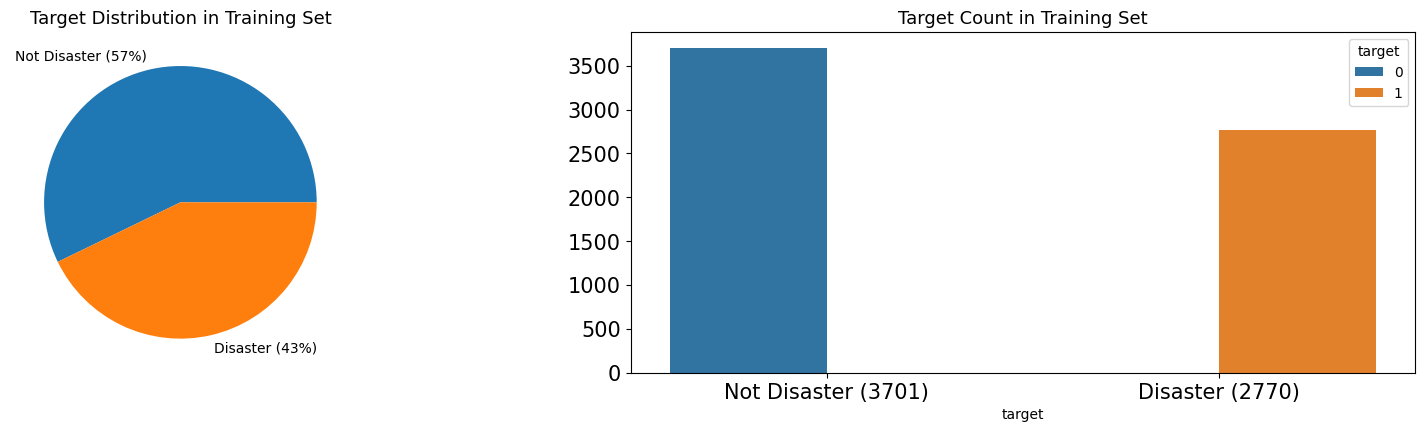

In [114]:
#Plotting the results above in a more visual way
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (3701)', 'Disaster (2770)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

Here's a little analysis on  keywords. We can see that the most common keyword is "deluge". The number of each associated target associated to each keyword is then counted. The conclusion is that frequent keywords are not necessarily associated with real tweets. What is interesting is that the keyword "wrecked" is almos always associated with real tweets, but "wreckage" is the opposite. We can conclude that the keyword has it influence on the tweet evaluatio.n

In [115]:
#Counting keyword occurencies
display(df.keyword.value_counts())

deluge                   39
earthquake               38
harm                     37
collision                37
collided                 36
                         ..
forest%20fire            18
epicentre                10
threat                   10
radiation%20emergency     9
inundation                6
Name: keyword, Length: 221, dtype: int64

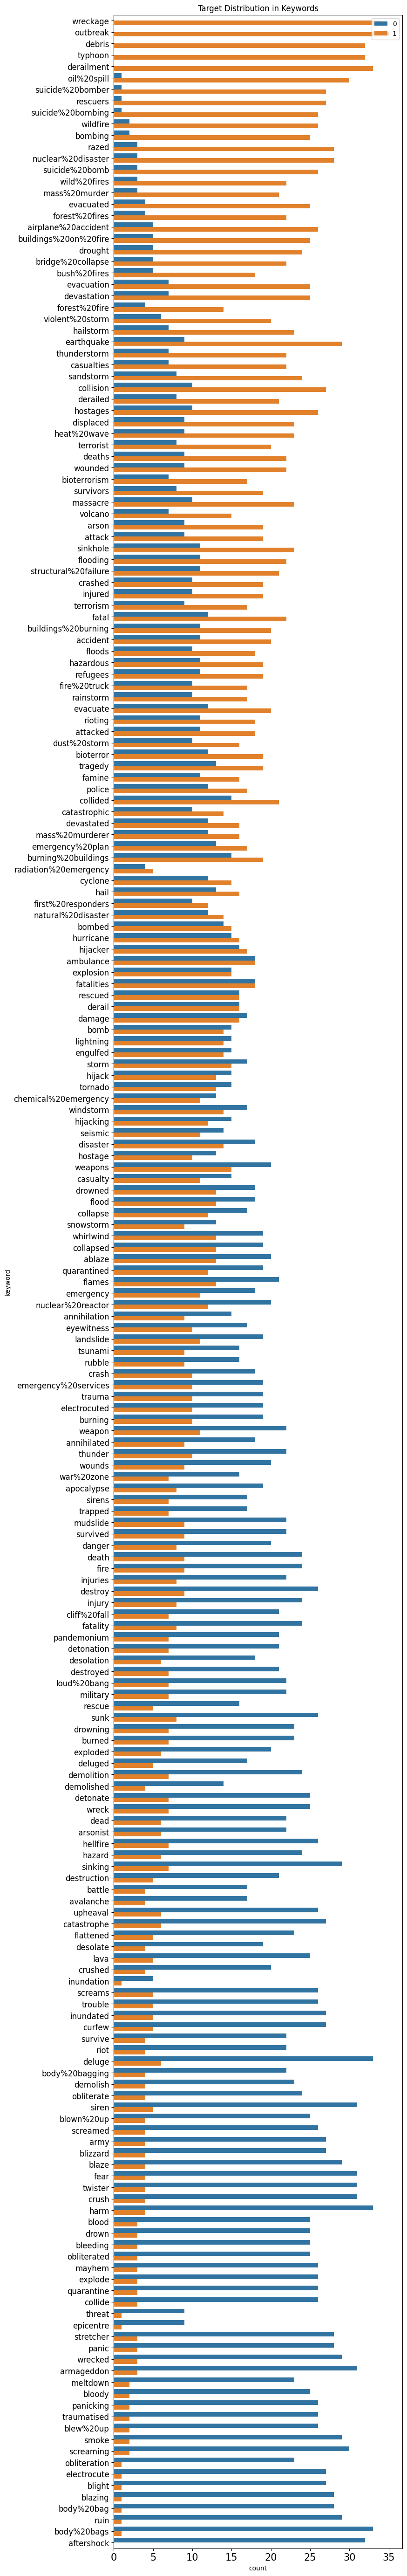

In [116]:
#Plotting the keywords by the nomber of each associated target
df['target_mean'] = df.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df.drop(columns=['target_mean'], inplace=True)


## 3. Preparing data

As the keyword has its influence, they are be given more weight by adding it to the text. The results have shown that this technique increases the accuracy. It's done on both sets.

In [117]:
#Replacing Nan values with #, wich will be removed in the tokenizer
df.keyword.fillna('#', inplace=True)
#Aggregation of text and keyword
df['x'] = df['keyword']+ ' ' + df['text'] 
df.drop('text',axis='columns', inplace=True)
df = df.rename({'x': 'text'}, axis=1)
df['text'] = df['text'].str.replace('nan', "")
df['text']

0       destroyed Black Eye 9: A space battle occurred...
1       bioterror #world FedEx no longer to transport ...
2       windstorm Reality Training: Train falls off el...
3       hazardous #Taiwan Grace: expect that large roc...
4       hostage New ISIS Video: ISIS Threatens to Behe...
                              ...                        
6466    earthquake #Earthquake #Sismo M 1.9 - 15km E o...
6467    derail @EmiiliexIrwin Totally agree.She is 23 ...
6468    trapped Hollywood Movie About Trapped Miners R...
6469    weapons Friendly reminder that the only countr...
6470    buildings%20on%20fire Buildings are on fire an...
Name: text, Length: 6471, dtype: object

In [118]:
#Same operation for the test set
df_test.keyword.fillna('#', inplace=True)
df_test['x'] = df_test['keyword']+ ' ' + df_test['text'] 
df_test.drop('text',axis='columns', inplace=True)
df_test = df_test.rename({'x': 'text'}, axis=1) 
df_test['text'] = df_test['text'].str.replace('nan', "")
df_test['text']

0       tsunami Crptotech tsunami and banks.\n http://...
1       traumatised I'm that traumatised that I can't ...
2       burning%20buildings @foxnewsvideo @AIIAmerican...
3       desolate Me watching Law &amp; Order (IB: @sau...
4               crushed Papi absolutely crushed that ball
                              ...                        
1137    derailed @ItsQueenBaby I'm at work it's a bunc...
1138    suicide%20bomber #?? #?? #??? #??? Suicide bom...
1139    volcano Eruption of Indonesian volcano sparks ...
1140    fear Never let fear get in the way of achievin...
1141    refugees wowo--=== 12000 Nigerian refugees rep...
Name: text, Length: 1142, dtype: object

## 4. Tokenizer & TF-IDF

We use the spacy-tokenizer, which has shown the best results. Punctations, numbers and mentions are taken in account. Special suffixes are also removed. The TF-IDF vectorizer is defined bellow. The arguments were chosen based on mutliple tests.

In [119]:
sp = spacy.load('en_core_web_sm')
import re
# Create tokenizer function
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    numbers = "0123456789"
    mentions = "(@[A-Za-z0–9]+)|([⁰-9A-Za-z \t])|(\w+:\/\/\S+)" 

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = [ word for word in mytokens if word not in mentions ]

    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

      # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
      for char in word:
        if (char in punctuations) or (char in numbers):
          word = word.replace(char, "")
      if word != "":
        mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2


In [120]:
#Defining the vectorizer
tfidf_vector = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

## 5. Train/test splitting

Here are defined the X_train, X_test and y_train values

In [121]:
#train/test 

X_train = df["text"]
y_train = df['target']
X_test = df_test["text"]

display((X_train,y_train,X_test))

(0       destroyed Black Eye 9: A space battle occurred...
 1       bioterror #world FedEx no longer to transport ...
 2       windstorm Reality Training: Train falls off el...
 3       hazardous #Taiwan Grace: expect that large roc...
 4       hostage New ISIS Video: ISIS Threatens to Behe...
                               ...                        
 6466    earthquake #Earthquake #Sismo M 1.9 - 15km E o...
 6467    derail @EmiiliexIrwin Totally agree.She is 23 ...
 6468    trapped Hollywood Movie About Trapped Miners R...
 6469    weapons Friendly reminder that the only countr...
 6470    buildings%20on%20fire Buildings are on fire an...
 Name: text, Length: 6471, dtype: object, 0       0
 1       0
 2       1
 3       1
 4       1
        ..
 6466    1
 6467    0
 6468    1
 6469    1
 6470    1
 Name: target, Length: 6471, dtype: int64, 0       tsunami Crptotech tsunami and banks.\n http://...
 1       traumatised I'm that traumatised that I can't ...
 2       burning%20buildings 

## 6. GridSearch
After mutliple attempts, it has been found that LogisticRegression is the best classifier. A GridSearch is done on the pipeline that will be used on the hyper-parameter C. 

In [122]:
C = np.logspace(-4, 4, 50)
parameters = dict(classifier__C=C)

classifier = LogisticRegression(solver="lbfgs", random_state=72, n_jobs=2, max_iter=5000)

# Create pipeline 
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
 

clf = GridSearchCV(pipe, parameters) 
clf.fit(X_train, y_train)
sorted(clf.cv_results_.keys())


The best C parameter is 1.2067926406393288

In [123]:
#Printing the results and the complete LogisticRegression parameters
print(clf.cv_results_)
print('Best C:', clf.best_estimator_.get_params()['classifier__C'])
print(); print(clf.best_estimator_.get_params()['classifier'])


## 7. Classification and prediction

Based on the GridSearch results above, the classifier and the pipeline is defined. As usual, the train set is fitted the the prediction are calculated

In [124]:
# Define classifier
classifier = LogisticRegression(C=1.2067926406393288, max_iter=5000, n_jobs=2,
                   random_state=72)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred_s = pipe.predict(X_train)



In [125]:
y_pred.shape

(1142,)

The prediction accuracy equals 0.8583 (0.823 on AiCrowd)

In [126]:
#Printing the results
print(round(accuracy_score(y_train, y_pred_s), 4))

0.8583


In [127]:
#Exporting the results to a .csv file
test_text = pd.DataFrame(y_pred)
test_text.to_csv('test_text.csv' , index = False)

## 8. Accuracy progression & technique used

In [128]:
url = "https://raw.githubusercontent.com/TetraFaal/DMML-Project-Nvidia/master/documents/Performance_history.csv"
Perform = pd.read_csv(url)
Perform.Label.fillna('Cleaning + GridSearchCV(LR) + MergeKeywords', inplace=True)
Perform["date"]=pd.to_datetime(Perform.date)
Perform

,Description,Label,accuracy,date,Model,Params
0,First tokenization with simple cleaning with t...,Simple cleaning + LR CV,0.8007,2020-11-13,Logistic regression cv,"solver='lbfgs', cv=5, max_iter=5000, random_st..."
1,Changing logistic method,Cleaning + LR,0.8099,2020-11-13,Logistic regression,"solver=""lbfgs"", random_state=72, n_jobs=-1, ma..."
2,"Calculated base rate, further cleaning and mer...",Cleaning + LR + MergeKeywords,0.8204,2020-11-24,Logistic regression,"solver=""lbfgs"", random_state=72, n_jobs=-1, ma..."
3,Calculated optimal Logistic regression paramet...,Cleaning + GridSearchCV(LR),0.8222,2020-11-25,Logistic regression,"C=1.2067926406393288, max_iter=5000, n_jobs=2,..."
4,Calculated optimal Logistic regression paramet...,Cleaning + GridSearchCV(LR) + MergeKeywords,0.8230,2020-11-26,Logistic regression,"C=1.2067926406393288, max_iter=5000, n_jobs=2,..."
5,Calculated optimal TFIDF parameters -> Overfit...,GridSearchCV(TFIDF),0.8143,2020-11-26,Logistic regression,"analyzer='word', binary=False, decode_error='s..."
6,Merged optimal Log regression and tfidf parame...,GridSearchCV(TFIDF) +GridSearchCV(LR),0.8169,2020-11-26,Logistic regression,"C=1.0, class_weight=None, dual=False, fit_inte..."
7,Pca method : Pipe (KNN),PCA + KNN,0.7200,2020-11-30,KNN,K =15
8,Pca method : Pipe (Pca + LR),PCA + LR,0.7300,2020-11-30,Logistic regression,"max_iter=5000, n_jobs=2,random_state=72 ..."
9,Pca method : Pipe (Scaler + LR),Scaler + LR,0.7300,2020-11-30,Logistic regression,"max_iter=5000, n_jobs=2,random_state=72 ..."


Text(0.5, 1.0, 'Accuracies line\n')

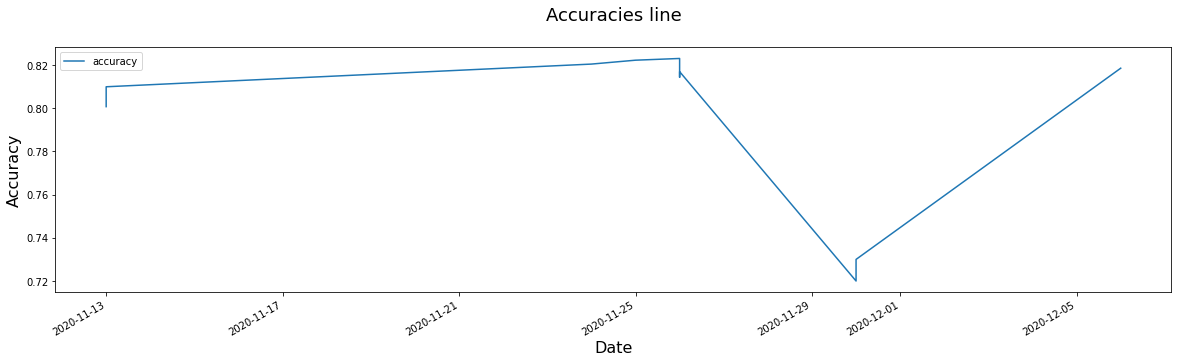

In [129]:
Perform.plot(kind='line',x='date',y='accuracy', figsize=(20,5))
plt.xlabel('Date', size = 16)
plt.ylabel('Accuracy', size = 16)
plt.title('Accuracies line'+"\n", size= 18) 